Given a sequence of {F|L|R}, each of which is "move forward one step", "turn left, then move forward one step", "turn right, then move forward one step":
1. which tours are closed?
2. what is the area enclosed by the tour?

In [4]:
import collections
import enum
import random
import os

import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
class Direction(enum.Enum):
    UP = 1
    RIGHT = 2
    DOWN = 3
    LEFT = 4
    
turn_lefts = {Direction.UP: Direction.LEFT, Direction.LEFT: Direction.DOWN,
              Direction.DOWN: Direction.RIGHT, Direction.RIGHT: Direction.UP}

turn_rights = {Direction.UP: Direction.RIGHT, Direction.RIGHT: Direction.DOWN,
               Direction.DOWN: Direction.LEFT, Direction.LEFT: Direction.UP}

def turn_left(d):
    return turn_lefts[d]

def turn_right(d):
    return turn_rights[d]


In [6]:
Step = collections.namedtuple('Step', ['x', 'y', 'dir'])
Mistake = collections.namedtuple('Mistake', ['i', 'step'])

In [7]:
def advance(step, d):
    if d == Direction.UP:
        return Step(step.x, step.y+1, d)
    elif d == Direction.DOWN:
        return Step(step.x, step.y-1, d)
    elif d == Direction.LEFT:
        return Step(step.x-1, step.y, d)
    elif d == Direction.RIGHT:
        return Step(step.x+1, step.y, d)

In [8]:
def step(s, current):
    if s == 'F':
        return advance(current, current.dir)
    elif s == 'L':
        return advance(current, turn_left(current.dir))
    elif s == 'R':
        return advance(current, turn_right(current.dir))
    else:
        raise ValueError

In [9]:
def trace_tour(tour, startx=0, starty=0, startdir=Direction.RIGHT):
    current = Step(startx, starty, startdir)
    trace = [current]
    for s in tour:
        current = step(s, current)
        trace += [current]
    return trace    

In [10]:
def positions(trace):
    return [(s.x, s.y) for s in trace]

In [11]:
def valid(trace):
    return (trace[-1].x == 0 
            and trace[-1].y == 0 
            and len(set(positions(trace))) + 1 == len(trace))

In [12]:
def valid_prefix(tour):
    current = Step(0, 0, Direction.RIGHT)
    prefix = []
    posns = []
    for s in tour:
        current = step(s, current)
        prefix += [s]
        if (current.x, current.y) in posns:
            return ''
        elif current.x == 0 and current.y == 0: 
            return ''.join(prefix)
        posns += [(current.x, current.y)]
    if current.x == 0 and current.y == 0:
        return ''.join(prefix)
    else:
        return ''

In [13]:
def mistake_positions(trace, debug=False):
    mistakes = []
    current = trace[0]
    posns = [(0, 0)]
    for i, current in enumerate(trace[1:]):
        if (current.x, current.y) in posns:
            if debug: print(i, current)
            mistakes += [Mistake(i+1, current)]
        posns += [(current.x, current.y)]
    if (current.x, current.y) == (0, 0):
        return mistakes[:-1]
    else:
        return mistakes + [Mistake(len(trace)+1, current)]

In [14]:
def returns_to_origin(mistake_positions):
    return [i for i, m in mistake_positions
           if (m.x, m.y) == (0, 0)]

In [15]:
sample_tours = ['FFLRLLFLRL', 'FLLFFLFFFLFFLFLLRRFR', 'FFRLLFRLLFFFRFLLRLLRRLLRLL']

In [16]:
def random_walk(steps=1000):
    return ''.join(random.choice('FFLR') for _ in range(steps))

In [17]:
def bounds(trace):
    return (max(s.x for s in trace),
            max(s.y for s in trace),
            min(s.x for s in trace),
            min(s.y for s in trace))

In [18]:
plot_wh = {Direction.UP: (0, 1), Direction.LEFT: (-1, 0),
           Direction.DOWN: (0, -1), Direction.RIGHT: (1, 0)}

In [27]:
def chunks(items, n=2):
    return [items[i:i+n] for i in range(len(items) - n + 1)]

In [19]:
def plot_trace(trace, colour='k', highlight_start=True,
               xybounds=None, fig=None, subplot_details=None, filename=None):
    plt.axis('on')
    plt.axes().set_aspect('equal')
        
    if highlight_start:
        plt.axes().add_patch(plt.Circle((trace[0].x, trace[0].y), 0.2, color=colour))
        
    for s, t in chunks(trace, 2):
        w, h = plot_wh[t.dir]
        plt.arrow(s.x, s.y, w, h, head_width=0.1, head_length=0.1, fc=colour, ec=colour, length_includes_head=True)
    xh, yh, xl, yl = bounds(trace)
    if xybounds is not None:    
        bxh, byh, bxl, byl = xybounds
        plt.xlim([min(xl, bxl)-1, max(xh, bxh)+1])
        plt.ylim([min(yl, byl)-1, max(yh, byh)+1])
    else:
        plt.xlim([xl-1, xh+1])
        plt.ylim([yl-1, yh+1])
    if filename:
        plt.savefig(filename)

In [20]:
def trim_loop(tour, random_mistake=False):
    trace = trace_tour(tour)
    mistakes = mistake_positions(trace)
    if random_mistake:
        end_mistake_index = random.randrange(len(mistakes))
    else:
        end_mistake_index = 0
#     print('end_mistake_index {} pointing to trace position {}; {} mistakes and {} in trace; {}'.format(end_mistake_index, mistakes[end_mistake_index].i, len(mistakes), len(trace), mistakes))
    # while this mistake extends to the next step in the trace...
    while (mistakes[end_mistake_index].i + 1 < len(trace) and 
           end_mistake_index + 1 < len(mistakes) and
           mistakes[end_mistake_index].i + 1 == 
           mistakes[end_mistake_index + 1].i):
#         print('end_mistake_index {} pointing to trace position {}; {} mistakes and {} in trace'.format(end_mistake_index, mistakes[end_mistake_index].i, len(mistakes), len(trace), mistakes))
        # push this mistake finish point later
        end_mistake_index += 1
    mistake = mistakes[end_mistake_index]
    
    # find the first location that mentions where this mistake ends (which the point where the loop starts)
    mistake_loop_start = max(i for i, loc in enumerate(trace[:mistake.i])
                             if (loc.x, loc.y) == (mistake.step.x, mistake.step.y))
#     print('Dealing with mistake from', mistake_loop_start, 'to', mistake.i, ', trace has len', len(trace))
    
    # direction before entering the loop
    direction_before = trace[mistake_loop_start].dir
    
    # find the new instruction to turn from heading before the loop to heading after the loop
    new_instruction = 'F'
    if (mistake.i + 1) < len(trace):
        if turn_left(direction_before) == trace[mistake.i + 1].dir:
            new_instruction = 'L'
        if turn_right(direction_before) == trace[mistake.i + 1].dir:
            new_instruction = 'R'
#     if (mistake.i + 1) < len(trace):
#         print('turning from', direction_before, 'to', trace[mistake.i + 1].dir, 'with', new_instruction )
#     else:
#         print('turning from', direction_before, 'to BEYOND END', 'with', new_instruction )
    return tour[:mistake_loop_start] + new_instruction + tour[mistake.i+1:]
#     return mistake, mistake_loop_start, trace[mistake_loop_start-2:mistake_loop_start+8]

In [21]:
def trim_all_loops(tour, mistake_reduction_attempt_limit=10):
    trace = trace_tour(tour)
    mistake_limit = 1
    if trace[-1].x == 0 and trace[-1].y == 0:
        mistake_limit = 0
    mistakes = mistake_positions(trace)
    
    old_mistake_count = len(mistakes)
    mistake_reduction_tries = 0
    
    while len(mistakes) > mistake_limit and mistake_reduction_tries < mistake_reduction_attempt_limit:
        tour = trim_loop(tour)
        trace = trace_tour(tour)
        mistakes = mistake_positions(trace)
        if len(mistakes) < old_mistake_count:
            old_mistake_count = len(mistakes)
            mistake_reduction_tries = 0
        else:
            mistake_reduction_tries += 1
    if mistake_reduction_tries >= mistake_reduction_attempt_limit:
        return ''
    else:
        return tour

In [22]:
def reverse_tour(tour):
    def swap(tour_step):
        if tour_step == 'R':
            return 'L'
        elif tour_step == 'L':
            return 'R'
        else:
            return tour_step
        
    return ''.join(swap(s) for s in reversed(tour))

In [23]:
def wander_near(locus, current, limit=10):
    valid_proposal = False
    while not valid_proposal:
        s = random.choice('FFFRL')
        if s == 'F':
            proposed = advance(current, current.dir)
        elif s == 'L':
            proposed = advance(current, turn_left(current.dir))
        elif s == 'R':
            proposed = advance(current, turn_right(current.dir))
        if abs(proposed.x - locus.x) < limit and abs(proposed.y - locus.y) < limit:
            valid_proposal = True
#     print('At {} going to {} by step {} to {}'.format(current, locus, s, proposed))
    return s, proposed

In [24]:
def seek(goal, current):
    dx = current.x - goal.x
    dy = current.y - goal.y

    if dx < 0 and abs(dx) > abs(dy): # to the left
        side = 'left'
        if current.dir == Direction.RIGHT:
            s = 'F'
        elif current.dir == Direction.UP:
            s = 'R'
        else:
            s = 'L'
    elif dx > 0 and abs(dx) > abs(dy): # to the right
        side = 'right'
        if current.dir == Direction.LEFT:
            s = 'F'
        elif current.dir == Direction.UP:
            s = 'L'
        else:
            s = 'R'
    elif dy > 0 and abs(dx) <= abs(dy): # above
        side = 'above'
        if current.dir == Direction.DOWN:
            s = 'F'
        elif current.dir == Direction.RIGHT:
            s = 'R'
        else:
            s = 'L'
    else: # below
        side = 'below'
        if current.dir == Direction.UP:
            s = 'F'
        elif current.dir == Direction.LEFT:
            s = 'R'
        else:
            s = 'L'
    if s == 'F':
        proposed = advance(current, current.dir)
    elif s == 'L':
        proposed = advance(current, turn_left(current.dir))
    elif s == 'R':
        proposed = advance(current, turn_right(current.dir))
        
#     print('At {} going to {}, currently {},  by step {} to {}'.format(current, goal, side, s, proposed))

    return s, proposed

In [25]:
def guided_walk(loci, locus_limit=5, wander_limit=10, seek_step_limit=20, return_anyway=False):
    trail = ''
    current = Step(0, 0, Direction.RIGHT)    
    l = 0
    finished = False
    while not finished:
        if abs(current.x - loci[l].x) < locus_limit and abs(current.y - loci[l].y) < locus_limit:
            l += 1
            if l == len(loci) - 1:
                finished = True
        s, proposed = wander_near(loci[l], current, limit=wander_limit)
        trail += s
        current = proposed
#     print('!! Finished loci')
    seek_steps = 0
    while not (current.x == loci[l].x and current.y == loci[l].y) and seek_steps < seek_step_limit:
#         error = max(abs(current.x - loci[l].x), abs(current.y - loci[l].y))
#         s, proposed = wander_near(loci[l], current, limit=error+1)
        s, proposed = seek(loci[l], current)
        trail += s
        current = proposed
        seek_steps += 1
    if seek_steps >= seek_step_limit and not return_anyway:
        return ''
    else:
        return trail

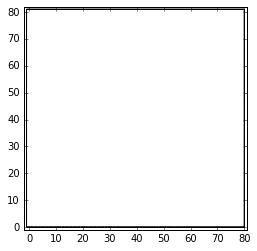

In [28]:
def square_tour(a=80):
    "a is width of square"
    return ('F' * a + 'L') * 4

plot_trace(trace_tour(square_tour()))

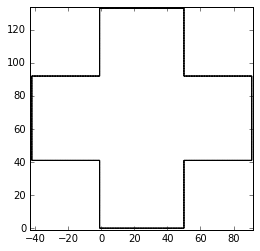

In [29]:
def cross_tour(a=50, b=40):
    "a is width of cross arm, b is length of cross arm"
    return ('F' *  a + 'L' + 'F' * b + 'R' + 'F' * b + 'L') * 4

plot_trace(trace_tour(cross_tour()))

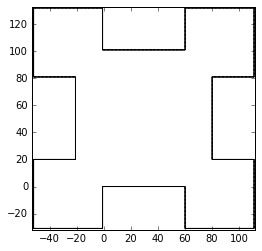

In [30]:
def quincunx_tour(a=60, b=30, c=50):
    "a is length of indent, b is indent/outdent distance, c is outdent outer length"
    return ('F' * a + 'R' + 'F' * b + 'L' + 'F' * c + 'L' + 'F' * c + 'L' + 'F' * b + 'R') * 4
plot_trace(trace_tour(quincunx_tour()))

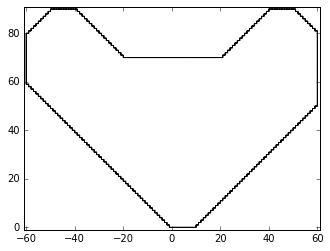

In [31]:
heart_points = [Step(60, 50, Direction.UP), Step(50, 90, Direction.UP),
                Step(20, 70, Direction.UP), 
                Step(-40, 90, Direction.UP), Step(-60, 80, Direction.UP), 
                Step(0, 0, Direction.RIGHT)]

heart_tour = ''
current = Step(0, 0, Direction.RIGHT)

for hp in heart_points:
    while not (current.x == hp.x and current.y == hp.y):
        s, proposed = seek(hp, current)
        heart_tour += s
        current = proposed

plot_trace(trace_tour(heart_tour))

def heart_tour_func(): return heart_tour

In [32]:
def trim_some_mistakes(tour, mistake_limit):
    trimmed_tour = rw
    mistake_count = len(mistake_positions(trace_tour(trimmed_tour)))
    while len(mistake_positions(trace_tour(trimmed_tour))) > mistake_limit:
        trimmed_tour = trim_loop(trimmed_tour, random_mistake=True)
    return trimmed_tour

In [33]:
!ls *txt

cross.txt	   small-squares.txt	  tours.txt
large-squares.txt  tours-open.txt	  tours-with-mistakes.txt
quincunx.txt	   tours-random-walk.txt


In [46]:
valid_tours = [t.strip() for t in open('tours.txt').readlines() if valid(trace_tour(t.strip()))]
valid_tours += [t.strip() for t in open('tours-with-mistakes.txt').readlines() if valid(trace_tour(t.strip()))]
valid_tours += [t.strip() for t in open('tours-open.txt').readlines() if valid(trace_tour(t.strip()))]
valid_tours += [t.strip() for t in open('tours-random-walk.txt').readlines() if valid(trace_tour(t.strip()))]

len(valid_tours)

113

In [35]:
all(valid(trace_tour(t)) for t in valid_tours)

True

In [47]:
tours_with_mistakes = [t.strip() for t in open('tours-with-mistakes.txt').readlines() 
                       if not valid(trace_tour(t.strip()))]
len(tours_with_mistakes)

(87, 0)

In [48]:
tours_open = [t.strip() for t in open('tours-open.txt').readlines() 
                       if not valid(trace_tour(t.strip()))]
len(tours_open)

100

In [50]:
tours_walks_loops = [t.strip() for t in open('tours-random-walk.txt').readlines() 
                       if len(mistake_positions(trace_tour(t.strip()))) > 1]
tours_walks_unloops = [t.strip() for t in open('tours-random-walk.txt').readlines() 
                       if len(mistake_positions(trace_tour(t.strip()))) == 1]
len(tours_walks_loops), len(tours_walks_unloops)

(84, 116)

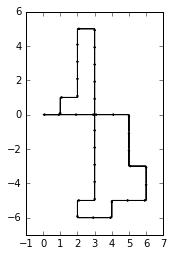

In [51]:
plot_trace(trace_tour(tours_with_mistakes[31]))

In [54]:
sum(1 for t in valid_tours if len(t) > 100)

65

In [92]:
problem_set = [t for t in valid_tours if len(t) <= 100]
len(problem_set)

48

In [93]:
# problem_set += [t for t in valid_tours if len(t) > 100][0::2]
valids_to_split = [t for t in valid_tours if len(t) > 100]
len(problem_set), len(valids_to_split)

(48, 65)

In [94]:
problem_set += random.sample(tours_with_mistakes + tours_open + tours_walks_loops + tours_walks_unloops, 100)
len(problem_set)

148

In [95]:
max(len(t) for t in valids_to_split)

2284

In [96]:
sum(len(t) for t in problem_set if valid(trace_tour(t)))

1680

In [85]:
[(i, j) 
 for i in range(len(problem_set)) 
 for j in range(len(problem_set))
 if i != j
 if valid(trace_tour(problem_set[i] + problem_set[j]))]

[]

In [87]:
split_valids = []
unsplit_valids = []
i = 0
for v in valids_to_split:
    can_add = False
    attempts_remaining = 500
    print('attempting', i)
    while not can_add and attempts_remaining > 0:
        # print('splitting', i, 'attempt', attempts_remaining)
        attempts_remaining -= 1
#         split_pos = len(v) // 2 + random.randrange(10)
        split_pos = random.randint(20, len(v) - 40)
        vl = v[:split_pos]
        vr = v[split_pos:]
        can_add = True
        if valid(trace_tour(vr + vl)): can_add = False
        for other in problem_set:
            if can_add and valid(trace_tour(other + vl)): can_add = False
            if can_add and valid(trace_tour(other + vr)): can_add = False
            if can_add and valid(trace_tour(vl + other)): can_add = False
            if can_add and valid(trace_tour(vr + other)): can_add = False
        for other in split_valids:
            if can_add and valid(trace_tour(other + vl)): can_add = False
            if can_add and valid(trace_tour(other + vr)): can_add = False
            if can_add and valid(trace_tour(vl + other)): can_add = False
            if can_add and valid(trace_tour(vr + other)): can_add = False
    if can_add:
        split_valids += [vl, vr]
        print('** found split for', i)
    else:
        unsplit_valids += [v]
    i += 1

attempting 0
** found split for 0
attempting 1
attempting 2
attempting 3
attempting 4
attempting 5
attempting 6
attempting 7
attempting 8
attempting 9
attempting 10
attempting 11
** found split for 11
attempting 12
attempting 13
attempting 14
attempting 15
attempting 16
attempting 17
** found split for 17
attempting 18
attempting 19
attempting 20
attempting 21
attempting 22
attempting 23
attempting 24
attempting 25
attempting 26
attempting 27
attempting 28
attempting 29
** found split for 29
attempting 30
attempting 31
attempting 32
attempting 33
attempting 34
** found split for 34
attempting 35
attempting 36
attempting 37
attempting 38
** found split for 38
attempting 39
attempting 40
attempting 41
** found split for 41
attempting 42
attempting 43
attempting 44
attempting 45
attempting 46
attempting 47
attempting 48
** found split for 48
attempting 49
** found split for 49
attempting 50
** found split for 50
attempting 51
attempting 52
attempting 53
attempting 54
attempting 55
attempt

In [97]:
split_valids[:4]

['RLFLRFRLLFFRRLFFFRFLLFFFLFLRFRFFFRFLLFRFRFFFFRFFLFLFLRRFRFFFFLFFFFFFRLFLFLFRRFFFLFRFFRRFLLFFFRFRFFLRLFFLFRFFFLFFFFLRFFFFFLFFRLFFFFFFFFRFFFFFFRFFFFFFRLFFFLFRFRFLFFFFLFFFFFFLRFFFFLRLFFRFFRFLFFFFFFFLFLRFRLFFFFFFRLRFFLFFRFRLFFFRLFRLFFFLFFRLFLFFLFRRFFFLRFFLFFLRFFRFLRFFFLFFRFFLRFFFFFRFLFRLFRRFLFFFFRRFLRLFLFFFFFFLFFFFFFRFLRLFRLFLFFRFFLFFFFFFRRFFFLLFFRFFLRFFRRLLFRFFFFFFLFFFLFFFLRFFLFRRFLRLRFFFRFLFFFFFRLRFLFLFFRRFLFFFRLLFRLLRRLFLFRFFRFLFFFFRFFFLFFLFRFRFLRFFFFFLRFLFLFFFRFFFLFRRFLFLFFLFFRFFFFFFRRFLFFRFFFLRFLFFFFFFFFLRFFRRLFFFFFLRLFFFFFRLFFFFFFFFFFFLRFFLFRFFFFLRLLFRFRLRFFFLFLFFFRFFFFFRFFRFFLFRLLFRFLRFFFFLFFLFRFFFRLFFRRFLRLFLFFFLRFLRFFFFFFLFFFRFRFFFFFF',
 'LLRRLFFFFFFFLFFFRFFFFFFFLLRFFRFFFRFFFLLFFRLRFFFLFRFFRFLFRFFFRFLLFFLFFFFFFRRFLRFRLFFFLFFFFFFFFLFFRLFFFFRFFFRFFFLFFFRLR',
 'RLFFFLFFFRFFFRFFLFFLFFRFFFFLFFRFRFFFRFLLRLFFFFLFFRFRFFRLRFFLFLFFRFFLFLRFRFFFLFFFLFRFLFFFFRRLFRFLFFFFFFLFRFFLFRFFFFFFFFLLFRFFFLFRFFRFFFFFFFRRLFLLRFFRLFRLFFFLFFRFFRFRFLFFLFFRFFFRLLFFFLFFFLRFFFFFFRLFRFFLFFFFRLFFRRLLFFFFLRLFFFFR

In [98]:
[(i, j) 
 for i in range(len(split_valids)) 
 for j in range(len(split_valids))
 if i != j
 if valid(trace_tour(split_valids[i] + split_valids[j]))]

[(0, 1),
 (2, 3),
 (4, 5),
 (6, 7),
 (8, 9),
 (10, 11),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19),
 (20, 21),
 (22, 23),
 (24, 25)]

In [99]:
problem_set += (split_valids + unsplit_valids)
len(problem_set)

226

In [100]:
with open('06-tours.txt', 'w') as f:
    f.writelines(t + '\n' for t in random.sample(problem_set, len(problem_set)))